In [1]:
import tweepy
import csv
from tweepy import OAuthHandler

consumer_key = ""
consumer_secret = ""
access_token = ""
access_secret = ""

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

In [2]:
def get_all_tweets(screen_name):
    #Twitter only allows access to a users most recent 3240 tweets with this method
    #authorize twitter, initialize tweepy
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    api = tweepy.API(auth)
    # initialize a list to hold all the tweepy Tweets
    alltweets = []
    # make initial request for most recent tweets (200 is the maximum allowed count)
    new_tweets = api.user_timeline(screen_name = screen_name,count=200)
    # save most recent tweets
    alltweets.extend(new_tweets)
    # save the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1
    # keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:
        print "getting tweets before %s" % (oldest)
        #all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest)
        #save most recent tweets
        alltweets.extend(new_tweets)
        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1
        print "...%s tweets downloaded so far" % (len(alltweets))
    # transform the tweepy tweets into a 2D array that will populate the csv
    outtweets = [[tweet.id_str, tweet.created_at, tweet.text.encode("utf-8")] for tweet in alltweets]
    # write the csv
    with open('%s_tweets.csv' % screen_name, 'wb') as f:
        writer = csv.writer(f)
        writer.writerow(["id","created_at","text"])
        writer.writerows(outtweets)
    pass

In [3]:
get_all_tweets("co2_live")

getting tweets before 765820494239174655
...400 tweets downloaded so far
getting tweets before 753152033885216768
...600 tweets downloaded so far
getting tweets before 749362153988259839
...800 tweets downloaded so far
getting tweets before 746236635931508735
...1000 tweets downloaded so far
getting tweets before 741887888569323520
...1200 tweets downloaded so far
getting tweets before 737373072714563583
...1400 tweets downloaded so far
getting tweets before 733990927656726528
...1600 tweets downloaded so far
getting tweets before 729747895306563584
...1800 tweets downloaded so far
getting tweets before 726546677386063873
...2000 tweets downloaded so far
getting tweets before 722560546051121151
...2200 tweets downloaded so far
getting tweets before 718060767216607232
...2400 tweets downloaded so far
getting tweets before 713757445068365823
...2434 tweets downloaded so far
getting tweets before 713047829737050111
...2434 tweets downloaded so far


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [5]:
dat = pd.read_csv("./co2_live_tweets.csv")
dat.head()

,id,created_at,text
0,770003057103044608,2016-08-28 21:00:09,Current CO₂ level in Edinburgh: 600 ppm #viewco2
1,769988045563170816,2016-08-28 20:00:30,Current CO₂ level in Edinburgh: 602 ppm #viewco2
2,769972982752145408,2016-08-28 19:00:39,Current CO₂ level in Edinburgh: 557 ppm #viewco2
3,769957735358226432,2016-08-28 18:00:03,Current CO₂ level in Edinburgh: 562 ppm #viewco2
4,769942752809349120,2016-08-28 17:00:31,Current CO₂ level in Edinburgh: 525 ppm #viewco2


So we need to extract the ppm values from the `text` column, and also watch out for non-standard tweets.

In [6]:
# remove non-standard rows
dat = dat[dat["text"].str.startswith("Current CO")]

# extract ppm value from text
ppm_nested = []
for row in dat.text:
    ppm_nested.append([int(s) for s in row.split() if s.isdigit()])

# flatten list
ppm = [val for sublist in ppm_nested for val in sublist]

dat["co2"] = ppm

In [7]:
dat.head()

,id,created_at,text,co2
0,770003057103044608,2016-08-28 21:00:09,Current CO₂ level in Edinburgh: 600 ppm #viewco2,600
1,769988045563170816,2016-08-28 20:00:30,Current CO₂ level in Edinburgh: 602 ppm #viewco2,602
2,769972982752145408,2016-08-28 19:00:39,Current CO₂ level in Edinburgh: 557 ppm #viewco2,557
3,769957735358226432,2016-08-28 18:00:03,Current CO₂ level in Edinburgh: 562 ppm #viewco2,562
4,769942752809349120,2016-08-28 17:00:31,Current CO₂ level in Edinburgh: 525 ppm #viewco2,525


In [8]:
# convert created_at column to datetime

dat["created_at"] = pd.to_datetime(dat["created_at"])

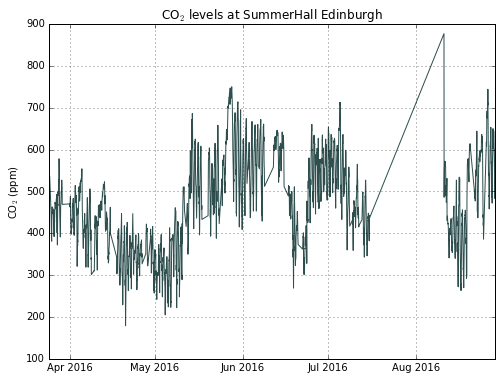

In [9]:
plt.figure(figsize=[8,6])
plt.plot(dat.created_at, dat.co2, color="darkslategrey")
plt.grid()
plt.ylabel(r"CO$_2$ (ppm)")
plt.title(r"CO$_2$ levels at SummerHall Edinburgh")
plt.show()

Looks like there's a big gap in recordings from mid July to mid August.

## Does time of day impact CO$_2$ levels?

In [10]:
# need to get the time from datetime
time = [i.time() for i in dat.created_at]
dat["time"] = time

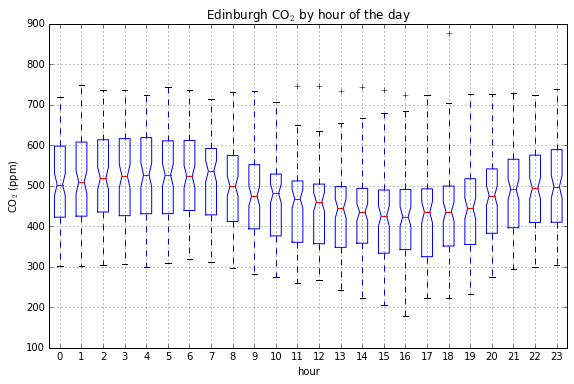

In [11]:
dat.time.head()
# remove the seconds so we have groups of data to the nearest hour

dat["hour"] = [i.hour for i in dat["time"]]
dat.boxplot(column="co2", by="hour", figsize=[9,6], notch=True)
plt.ylabel(r"CO$_2$ (ppm)")
plt.suptitle("")
plt.title(r"Edinburgh CO$_2$ by hour of the day")
plt.show()

Suprisingly (to me at least), CO$_2$ levels actually drop throughput the day and increase at night and the early morning. One explanation would be temperature.

## Does day of the week impact CO$_2$ levels?

In [12]:
day_int = [i.dayofweek for i in dat.created_at]
#day_str = ["Mon", "Tues", "Wed", "Thu", "Fri", "Sat", "Sun"]
#day = [day_str[i] for i in day_int]
dat["day"] = day_int

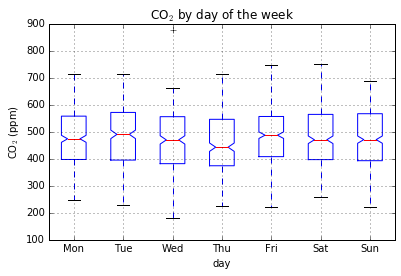

In [13]:
dat.boxplot(column="co2", by="day", figsize=[6,4], notch=True)
plt.suptitle("")
plt.title(r"CO$_2$ by day of the week")
plt.xticks(range(1, 8), ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.ylabel(r"CO$_2$ (ppm)")
plt.show()

Could do a statistical test to find if there is a slight difference, but from eye-balling it there's not real difference.